In [1]:
%run "../../shared/utilz_includez.ipynb"

In [2]:
from skimage import io, img_as_float, img_as_ubyte
from skimage import color

## filterrs and denoising
from scipy import ndimage as nd
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import exposure ## for histogram equalization 

##segmentation
from skimage.segmentation import random_walker

In [3]:
seg_colorz = [ (1, 0, 0), (0,1,0), (0,0,1), (1,1,0), (1,0,1), (0,1, 1), (1, 1, 1), (0,0,0) ]

def plot_image( img_array , plotit=True, title=None, cmapd='gray'):     
    print( f"\n{ '-'*7 } { title if title else type(img_array) } { '-'*7 }" )
    print( f"image.shape = {img_array.shape}" ) 
    print( f"datatype = {img_array.dtype}")
    print( f"min = {np.min(img_array)} , max = {np.max(img_array)}\n" )
    if plotit:
        if cmapd:
            plt.imshow( img_array , cmap=cmapd)
        else:
            plt.imshow( img_array )
    if title:
        plt.title(title)
        

def denoised_image(img, patch_size=5, patch_distance=3, multichannel=True):
    sig = np.mean( estimate_sigma(img, multichannel=True) )
    dimg = img_as_ubyte( 
        denoise_nl_means(img, h=1.15*sig, fast_mode=False, 
                         patch_size=patch_size, patch_distance=patch_distance, 
                         multichannel=multichannel) )
    return dimg

def gen_histogram_image( segz,  dimz, segz_c=seg_colorz ):  
    all_segz_cleaner = np.zeros( dimz )
    for seg, cr in zip(segz, segz_c):
        k = np.ones( (3,3)) 
        z = nd.binary_closing(   nd.binary_opening(  seg, k) ,  k)
        all_segz_cleaner[ z ] = cr
    return all_segz_cleaner 

# OpenCV
- Splitting channels, transformations, analysis 

In [4]:
imgpath = "cells.jpg" 
#"https://upload.wikimedia.org/wikipedia/commons/a/a0/SkinTumors-P7110453.JPG"
#imgpath = "https://www.jai.com/uploads/images/_transContentImage765xAuto/Skin-cells-bright-field.jpg"
#imgpath = "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR_X7PDZCN8vF_OWSVJD9WG_rU3WZMkG99nwdotwCM9uD3gp_X4&usqp=CAU"


## 1. View Image Segments


------- Original Image -------
image.shape = (990, 990, 3)
datatype = float64
min = 0.0 , max = 1.0


------- Denoised & Equalized image -------
image.shape = (990, 990, 3)
datatype = float64
min = 0.0 , max = 1.0


------- Grayscaled Image -------
image.shape = (990, 990)
datatype = float64
min = 0.0 , max = 1.0



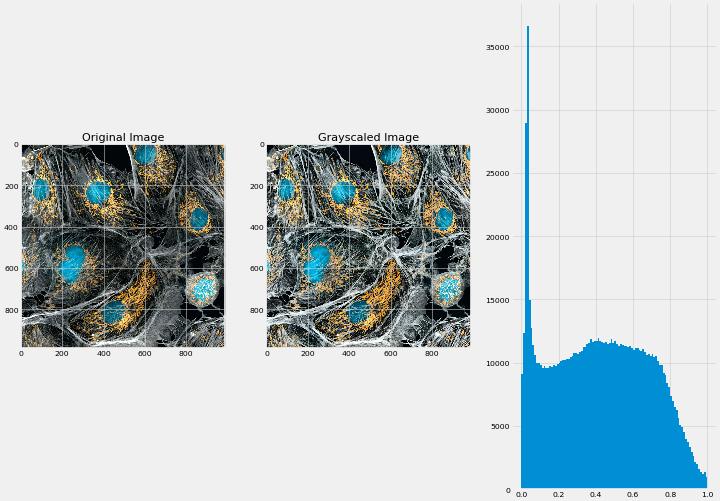

In [5]:
img = img_as_float( io.imread(imgpath, as_gray=False))

edimg = exposure.equalize_adapthist( denoised_image( img ) )

plt.subplot(1, 3, 1)
plot_image(img, title='Original Image')

plt.subplot(1, 3, 2)
plot_image( edimg , title='Denoised & Equalized image', plotit=True)

gray_edimg = color.rgb2gray( edimg )

plot_image( gray_edimg, title="Grayscaled Image", plotit=False)

plt.subplot( 1, 3, 3)
plt.hist( gray_edimg.flat, bins=100, range=(0,1)); 



------- Denoised & Equalized image -------
image.shape = (990, 990, 3)
datatype = float64
min = 0.0 , max = 1.0


------- RandomWalker Labelz -------
image.shape = (990, 990)
datatype = int32
min = 1 , max = 3


------- RandomWalker Colorized -------
image.shape = (990, 990, 3)
datatype = float64
min = 0.0 , max = 1.0



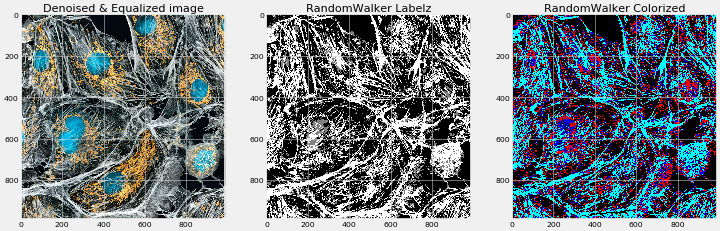

In [6]:
markerz = []
markerz = np.zeros( gray_edimg.shape, dtype=np.uint)

markerz[ (gray_edimg > 0.31) & (gray_edimg < 0.43)] = 1
markerz[ (gray_edimg > 0.45) & (gray_edimg < 0.55 )] = 2
markerz[ (gray_edimg > 0.6) & (gray_edimg < 0.95)] = 3


all_segz = np.zeros( (*gray_edimg.shape, 3) )
all_segz[ markerz == 1 ] = (1,0,0)
all_segz[ markerz == 2 ] = (0,0,1)
all_segz[ markerz == 3 ] = (0, 1, 1)

rimg = random_walker( gray_edimg, markerz, beta=10, mode='bf')


plt.subplot(1, 3, 1)
plot_image( edimg , title='Denoised & Equalized image', plotit=True)

plt.subplot(1,3, 2)
plot_image( rimg, title="RandomWalker Labelz"); 

plt.subplot(1,3, 3)
plot_image( all_segz, title="RandomWalker Colorized"); 

# 2. Open CV Operations

In [7]:
import cv2

TYPE: <class 'numpy.ndarray'>

------- Default (?2/1?) Read Original -------
image.shape = (990, 990, 3)
datatype = uint8
min = 0 , max = 255


------- Read Original as 0 = grayscale -------
image.shape = (990, 990)
datatype = uint8
min = 0 , max = 255


------- Read Original as 1 = color -------
image.shape = (990, 990, 3)
datatype = uint8
min = 0 , max = 255



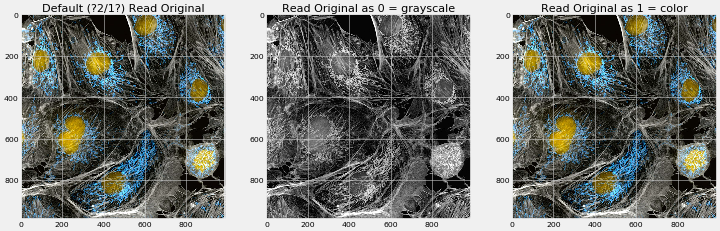

In [8]:
# local_imgpath = "furniture.png" ## Failing to read from network. TODO: how to do that 
cimg = cv2.imread( imgpath )
print( f"TYPE: {type(cimg)}")

plt.subplot(1, 3, 1)
plot_image( cimg, title='Default (?2/1?) Read Original') #default is color. 2 is include alpha channel

plt.subplot(1, 3, 2)
plot_image( cv2.imread( imgpath , 0), title='Read Original as 0 = grayscale')

plt.subplot(1, 3, 3)
plot_image( cv2.imread( imgpath , 1), title='Read Original as 1 = color'); 


------- Original Image -------
image.shape = (990, 990, 3)
datatype = float64
min = 0.0 , max = 1.0

[0.43137255 0.4627451  0.4745098 ]
[[[0.43137255 0.4627451  0.4745098 ]]]

------- Single pixed BGR@cv2 -------
image.shape = (1, 1, 3)
datatype = float64
min = 0.43137254901960786 , max = 0.4745098039215686


------- Slice of Original -------
image.shape = (229, 333, 3)
datatype = float64
min = 0.0 , max = 1.0



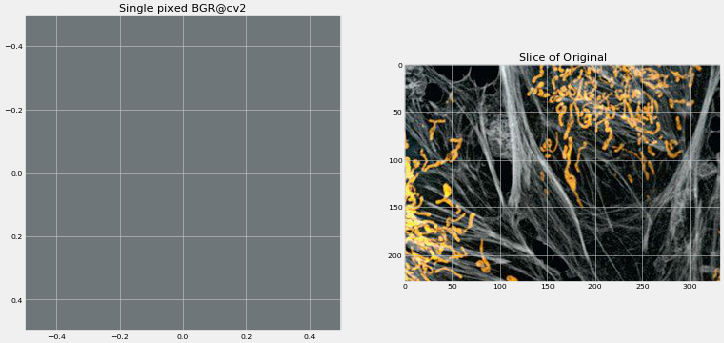

In [9]:
## Look at individualpized values or slices as per ndarray
plot_image( img, title="Original Image", plotit=False)

print( img[120, 435, :] )
print(img[120:121, 435:436, :])
plt.subplot(1,2,1)
plot_image( img[120:121, 435:436, :], title="Single pixed BGR@cv2")

plt.subplot(1,2,2)
plot_image( img[120:349, 435:768, :], title="Slice of Original"); 

In [10]:
## Display with CV2 so can zoom etc

def cv_plot(img, title):
    cv2.imshow( title, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    

### Reading channels

In [11]:
#cv_plot( img, 'Original Image')


------- Blue channel -------
image.shape = (990, 990)
datatype = float64
min = 0.0 , max = 1.0


------- Green channel -------
image.shape = (990, 990)
datatype = float64
min = 0.0 , max = 1.0


------- Red Channel -------
image.shape = (990, 990)
datatype = float64
min = 0.0 , max = 1.0



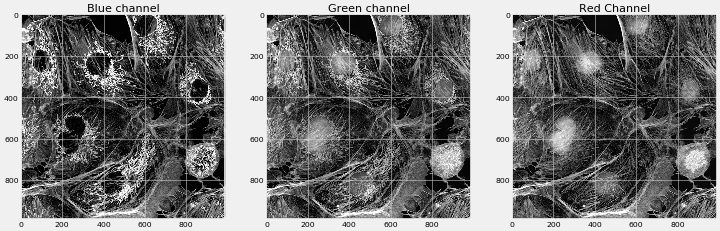

In [12]:
## Split into BGR channels using `split` and `merge` to merge 
blue, green, red = cv2.split( img )


plt.subplot(1,3,1)
plot_image( blue, title="Blue channel")

plt.subplot(1,3,2)
plot_image( green, title="Green channel")

plt.subplot(1,3,3)
plot_image( red, title="Red Channel"); 

### Resizing Images

In [13]:
#cv_plot( green, 'Green Channel')


------- Original Image -------
image.shape = (990, 990, 3)
datatype = float64
min = 0.0 , max = 1.0


------- Resized Image x2 -------
image.shape = (1980, 1980, 3)
datatype = float64
min = 0.0 , max = 1.0



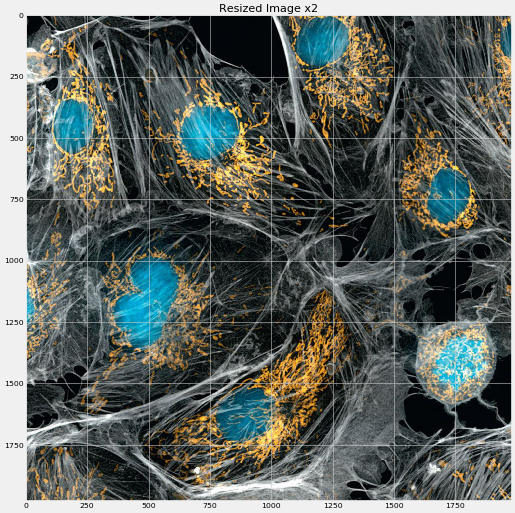

In [14]:
plot_image( img, title="Original Image", plotit=False)

plot_image( cv2.resize( img, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR), title='Resized Image x2' )

### Smothing, Denoising, Edge Detection 


------- Original Image -------
image.shape = (990, 990, 3)
datatype = float64
min = 0.0 , max = 1.0


------- 2D Custom Filter -------
image.shape = (990, 990, 3)
datatype = float64
min = 0.0025175502487216894 , max = 0.9965625830725193


------- Inbuilt Blur Filter -------
image.shape = (990, 990, 3)
datatype = float64
min = 0.0025175502299684305 , max = 0.9965625756475432


------- Inbuilt Gaussian Blur Filter -------
image.shape = (990, 990, 3)
datatype = float64
min = 0.0008281034581801471 , max = 0.9987173043045343


------- Inbuilt Median Blur Filter -------
image.shape = (990, 990, 3)
datatype = uint8
min = 0 , max = 255


------- Inbuilt Bilateral Blur Filter -------
image.shape = (990, 990, 3)
datatype = uint8
min = 0 , max = 255


------- Canny Edge -------
image.shape = (990, 990)
datatype = uint8
min = 0 , max = 255



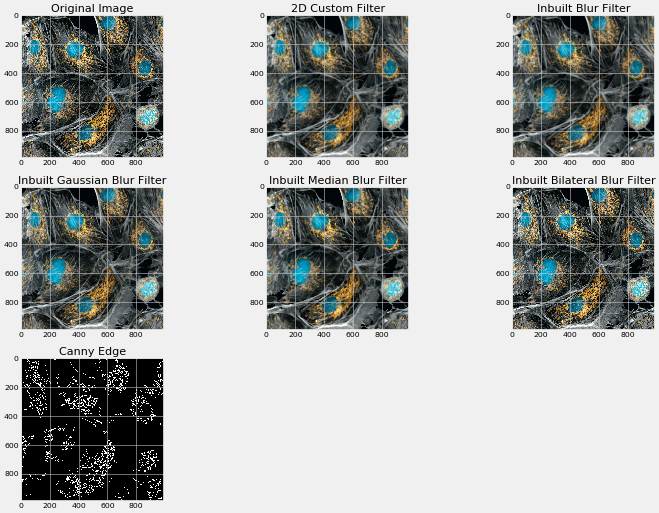

In [15]:
k = 9

n_rowz = 3
n_colz = 3

cleaner_kernel = np.ones( (k,k), np.float32) / k**2 ## normalize so that all sum to 1 and not change energy of the image
# print( f"Kernel {cleaner_kernel.shape}: \n", cleaner_kernel)
fimg = cv2.filter2D( img, -1, cleaner_kernel)

plt.subplot(n_rowz, n_colz, 1)
plot_image( img, title="Original Image")

plt.subplot(n_rowz, n_colz, 2)
plot_image( fimg, title="2D Custom Filter"); 

## this should be the exact same 
plt.subplot(n_rowz, n_colz, 3)
plot_image( cv2.blur(img, (k,k)), title="Inbuilt Blur Filter"); 

## gaussian blur - emphasis on central values 
plt.subplot(n_rowz, n_colz, 4)
plot_image( cv2.GaussianBlur(img, (k,k), 0), title="Inbuilt Gaussian Blur Filter"); 


### ===== NON-LINEAR METHODS; they preserve edges << Don't seem to work with float64

# ## Median
plt.subplot(n_rowz, n_colz, 5)
plot_image( cv2.medianBlur(img_as_ubyte(img), k), title="Inbuilt Median Blur Filter"); 

## Median
plt.subplot(n_rowz, n_colz, 6)
plot_image( cv2.bilateralFilter(img_as_ubyte(img), k, 0, 0), title="Inbuilt Bilateral Blur Filter"); 



### ==== EDGE DETECTION

plt.subplot(n_rowz, n_colz, 7)
plot_image( cv2.Canny( img_as_ubyte(img) , 850, 200), title="Canny Edge"); 



------- Original Image -------
image.shape = (298, 464, 3)
datatype = uint8
min = 0 , max = 255


------- Canny Edge -------
image.shape = (298, 464)
datatype = uint8
min = 0 , max = 255



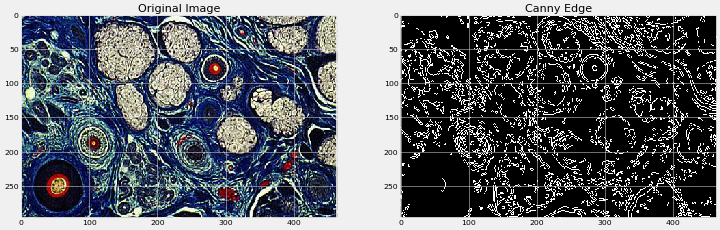

In [16]:
n_rowz = 2
n_colz = 2
gimg = io.imread('cells2.jpg') 


### ==== EDGE DETECTION
plt.subplot(n_rowz, n_colz, 1)
plot_image( gimg, title="Original Image"); 

plt.subplot(n_rowz, n_colz, 2)
plot_image( cv2.Canny( gimg , 1000, 500), title="Canny Edge"); 



**The above filter denoised some more. let's see what that does to the segmentation in previous section**


------- Grayscaled Image -------
image.shape = (990, 990)
datatype = float64
min = 0.0 , max = 1.0


------- Original Image -------
image.shape = (990, 990, 3)
datatype = float64
min = 0.0 , max = 1.0


------- Filtered -------
image.shape = (990, 990, 3)
datatype = float64
min = 0.0025175502487216894 , max = 0.9965625830725193



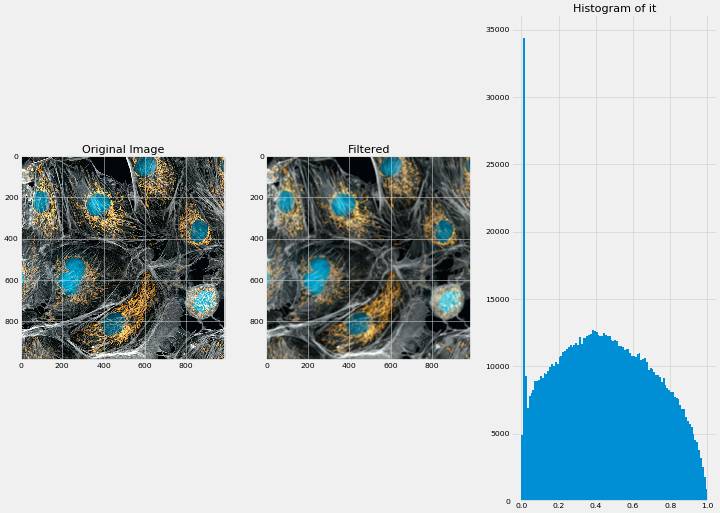

In [17]:
## The above filtere 
# fimg = cv2.bilateralFilter(img_as_ubyte(img), k, 0, 0 )
# fimg = img_as_float( cv2.Canny( img_as_ubyte(fimg), 900, 400) )
                    
gray_edimg = color.rgb2gray( fimg )

gray_edimg = exposure.equalize_adapthist( denoised_image( gray_edimg ) ) 


plot_image( gray_edimg, title="Grayscaled Image", plotit=False)

plt.subplot(1,3,1)
plot_image( img, title="Original Image")

plt.subplot(1,3,2)
plot_image( fimg, title="Filtered");

plt.subplot( 1, 3, 3)
plt.hist( gray_edimg.flat, bins=100, range=(0,1)); 
plt.title( 'Histogram of it'); 


------- Denoised & Equalized image -------
image.shape = (990, 990, 3)
datatype = float64
min = 0.0 , max = 1.0


------- RandomWalker Labelz -------
image.shape = (990, 990)
datatype = uint64
min = 1 , max = 5


------- RandomWalker Colorized -------
image.shape = (990, 990, 3)
datatype = float64
min = 0.0 , max = 1.0



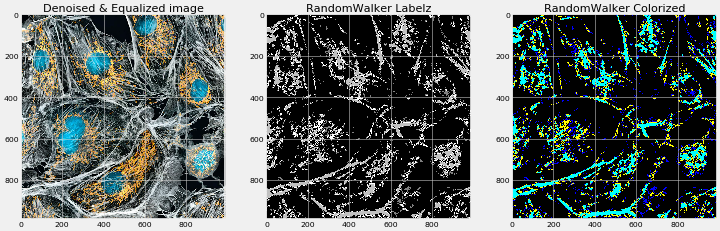

In [18]:
markerz = []
markerz = np.ones( gray_edimg.shape, dtype=np.uint)

# markerz[ (gray_edimg > 0.31) & (gray_edimg < 0.37)] = 1
# markerz[ (gray_edimg > 0.45) & (gray_edimg < 0.55 )] = 2
# markerz[ (gray_edimg > 0.6) & (gray_edimg < 0.95)] = 3


markerz[ (gray_edimg > 0.6) & (gray_edimg < 0.65)] = 2 #invaders
markerz[ (gray_edimg > 0.6) & (gray_edimg < 0.65 )] = 3 #nuclei

markerz[ (gray_edimg >= 0.83) & (gray_edimg <= 1)] = 4 #connectives
markerz[ (gray_edimg > 0.71) & (gray_edimg < 0.78)] = 5


all_segz = np.zeros( (*gray_edimg.shape, 3) )
all_segz[ markerz == 2 ] = (1,0,0)
all_segz[ markerz == 3 ] = (0,0,1)
all_segz[ markerz == 4 ] = (0, 1, 1)
all_segz[ markerz == 5 ] = (1, 1, 0)

rimg = random_walker( gray_edimg, markerz, beta=10, mode='bf')


plt.subplot(1, 3, 1)
plot_image( edimg , title='Denoised & Equalized image', plotit=True)

plt.subplot(1,3, 2)
plot_image( rimg, title="RandomWalker Labelz"); 

plt.subplot(1,3, 3)
plot_image( all_segz, title="RandomWalker Colorized"); 

### CLAHE Equalization and Thresholding
- CLAHE = Constrast Limiting Adaptive Histrogram Equalization. Does better than a global equalization. `skimage.exposure.equalize_adapthist`
    - Also check out `cv2.createCLAHE` 


------- Original image -------
image.shape = (1003, 700, 3)
datatype = uint8
min = 0 , max = 255


------- Canny Edges -------
image.shape = (1003, 700)
datatype = uint8
min = 0 , max = 255


------- CV2 Denoised & Equalized image -------
image.shape = (1003, 700)
datatype = uint8
min = 0 , max = 255


------- SK Denoised & Equalized image -------
image.shape = (1003, 700)
datatype = float64
min = 0.0 , max = 1.0



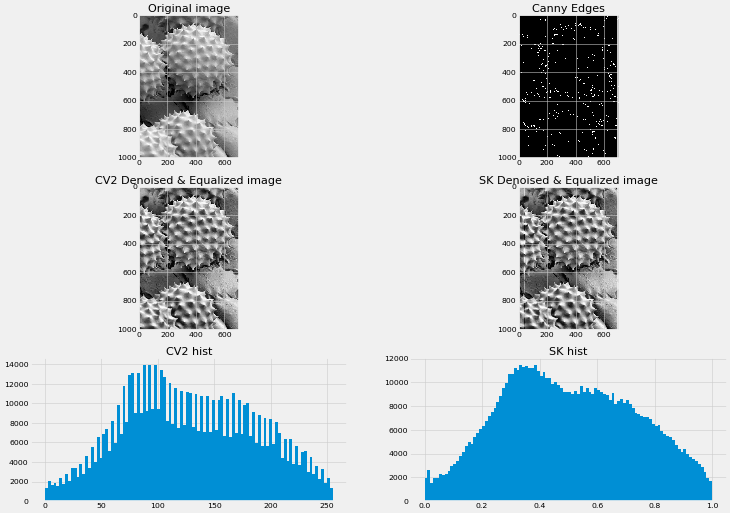

In [19]:
# ip = "https://live.staticflickr.com/3814/10582234095_c01a38cec0_z.jpg"
# ip = "https://thumbs.dreamstime.com/b/imagem-do-microsc%C3%B3pio-de-fluoresc%C3%AAncia-das-pilhas-humanas-que-submetem-se-%C3%A0-cariocinese-100397450.jpg"
# ip = "https://previews.123rf.com/images/drmicrobe/drmicrobe1802/drmicrobe180200010/94796009-histology-of-human-epididymis-tissue-micrograph-photo-under-microscope-.jpg"
# ip = "https://www.nikon.com/products/microscope-solutions/bioscience-applications/clinical/img/pathology_index_main.jpg"
# ip = "https://previews.123rf.com/images/vladnikon/vladnikon1702/vladnikon170200811/72100934-cells-under-microscope-diamonds-and-jewelry-3d-surreal-illustration-sacred-geometry-mysterious-psych.jpg"
ip = 'https://cdn.intechopen.com/books/images_new/6863.jpg'
img = io.imread( ip )
gray_edimg = color.rgb2gray( img )

#edimg = exposure.equalize_adapthist( denoised_image( gray_edimg ) ) ##<<using skimage
clahe = cv2.createCLAHE( clipLimit=2.0, tileGridSize=(8,8) )
edimg = clahe.apply( denoised_image( gray_edimg ) ) ## << using openCV
skimg = exposure.equalize_adapthist( denoised_image( gray_edimg ) )

n_colz=2
n_rowz=3

plt.subplot(n_rowz, n_colz, 1)
plot_image( img , title='Original image', plotit=True)

## Edges
plt.subplot(n_rowz, n_colz, 2)
plot_image( cv2.Canny( img_as_ubyte(edimg), 300, 200) , title="Canny Edges");

plt.subplot(n_rowz, n_colz, 3)
plot_image( edimg , title='CV2 Denoised & Equalized image', plotit=True); 


plt.subplot(n_rowz, n_colz, 4)
plot_image( skimg , title='SK Denoised & Equalized image', plotit=True); 


plt.subplot(n_rowz, n_colz, 5)
plt.hist( edimg.flat, bins=100, range=(0,255));
plt.title( 'CV2 hist')


plt.subplot(n_rowz, n_colz, 6)
plt.hist( skimg.flat, bins=100, range=(0,1));
plt.title( 'SK hist'); 


### Thresholding for segmentation
- Like we did with SKImage but now with CV


**1. Binary segmengation**
- `cv2.THRESH_BINARY` for which you define the threshold level and using 
- `cv2.THRESH_OTSU`, which auto finds the threshold value


------- First seg -------
image.shape = (1003, 700)
datatype = uint8
min = 0 , max = 150


------- Second seg -------
image.shape = (1003, 700)
datatype = uint8
min = 0 , max = 255



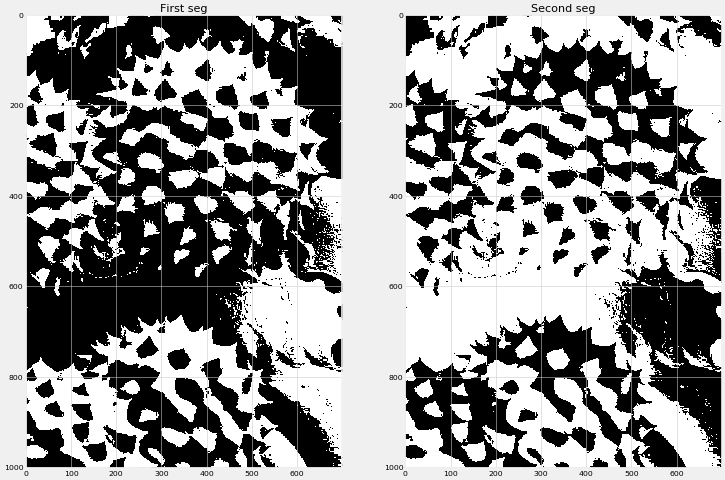

In [20]:
t_level = 140 ## from looking at the histogram 
_, thresh1 = cv2.threshold( edimg, t_level, 150, cv2.THRESH_BINARY) ## thresho
_, thresh2 = cv2.threshold( edimg, t_level, 255, cv2.THRESH_BINARY_INV) ## thresho

n_rowz=1
n_colz=2

plt.subplot(n_rowz, n_colz, 1)
plot_image( thresh1, title="First seg")

plt.subplot(n_rowz, n_colz, 2)
plot_image( thresh2, title="Second seg"); 



------- First seg with set t_level = 140 -------
image.shape = (1003, 700)
datatype = uint8
min = 0 , max = 150


------- First seg using OTSU = 132.0 -------
image.shape = (1003, 700)
datatype = uint8
min = 0 , max = 255



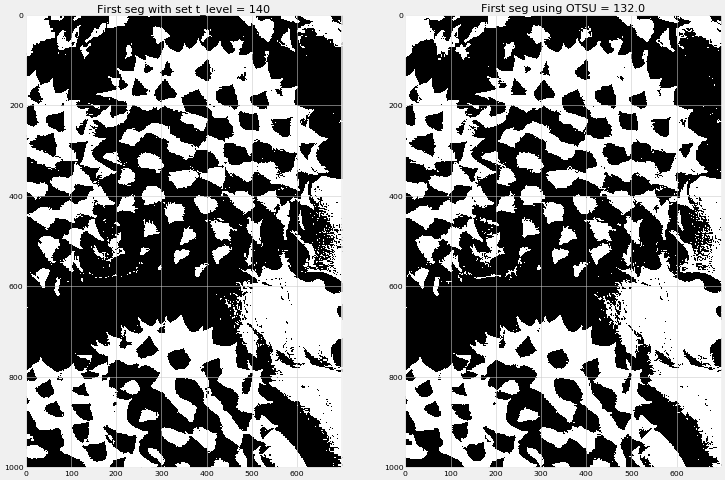

In [21]:
## Use OTSU
t_level = 140
_, thresh1 = cv2.threshold( edimg, t_level, 150, cv2.THRESH_BINARY) ## thresho
otsu, thresh2 = cv2.threshold( edimg, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) ## thresho

n_rowz=1
n_colz=2

plt.subplot(n_rowz, n_colz, 1)
plot_image( thresh1, title=f"First seg with set t_level = {t_level}")

plt.subplot(n_rowz, n_colz, 2)
plot_image( thresh2, title=f"First seg using OTSU = {otsu}"); 


### Thresholding and Morphological Operations
- 

In [22]:
# ip = 'https://casereports.bmj.com/content/casereports/2016/bcr-2015-213561/F1.large.jpg'
# ip = "https://img.bioopticsworld.com/files/base/ebm/bow/image/2017/07/content_dam_bow_online_articles_2017_07_oct_web.png?auto=format&w=720"
# ip = "https://d3i71xaburhd42.cloudfront.net/2c7fb8927dbb2cc47288ed8f660fe7bf49405118/3-Figure2-1.png"
ip = "https://pbs.twimg.com/media/CVzETgjW4AAzbWS.jpg"
img = io.imread( ip )

gray_img = img_as_ubyte(color.rgb2gray( img ))

##thresholded image
t, timg = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)


------- Original Image -------
image.shape = (900, 1200, 3)
datatype = uint8
min = 0 , max = 255


------- Grayscale Image -------
image.shape = (900, 1200)
datatype = uint8
min = 0 , max = 255


------- Thresholded Image at t = 158.0 -------
image.shape = (900, 1200)
datatype = uint8
min = 0 , max = 255



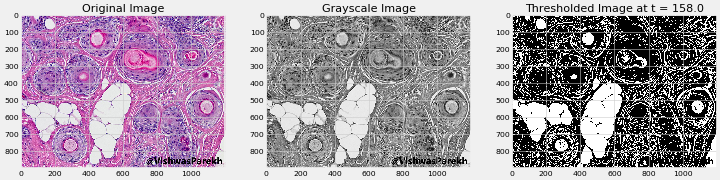

In [23]:
ncolz=3
nrowz=1
plt.subplot(nrowz, ncolz,  1)
plot_image(img, title='Original Image'); 

plt.subplot(nrowz, ncolz, 2)
plot_image(gray_img, title='Grayscale Image');

plt.subplot(nrowz, ncolz, 3)
plot_image(timg, title=f'Thresholded Image at t = {t}');


------- Thresholded Image at t = 158.0 -------
image.shape = (900, 1200)
datatype = uint8
min = 0 , max = 255


------- Eroded Image -------
image.shape = (900, 1200)
datatype = uint8
min = 0 , max = 255


------- Dilated Image -------
image.shape = (900, 1200)
datatype = uint8
min = 0 , max = 255


------- Eroded & Dilated Image -------
image.shape = (900, 1200)
datatype = uint8
min = 0 , max = 255


------- Open=Erode+Dilate Image -------
image.shape = (900, 1200)
datatype = uint8
min = 0 , max = 255


------- Close=Dilate+Erode Image -------
image.shape = (900, 1200)
datatype = uint8
min = 0 , max = 255



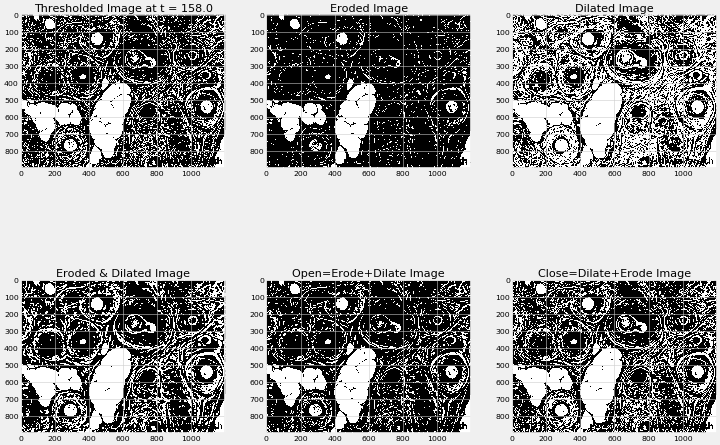

In [24]:
## 2. Erode and Dilate <<< is that similar to skimage.open/close << open === erode then dilate and closing = dilate then erode
kern = np.ones( (3,3) , np.uint8 )

nrowz=2
ncolz=3

plt.subplot(nrowz, ncolz, 1)
plot_image(timg, title=f'Thresholded Image at t = {t}');

plt.subplot(nrowz, ncolz, 2)
plot_image( cv2.erode(timg, kern, iterations=1), title='Eroded Image');

plt.subplot(nrowz, ncolz, 3)
plot_image( cv2.dilate(timg, kern, iterations=1), title='Dilated Image');


plt.subplot(nrowz, ncolz, 4)
plot_image( cv2.dilate( cv2.erode(timg, kern, iterations=1),kern, iterations=2 ), title='Eroded & Dilated Image');


plt.subplot(nrowz, ncolz, 5)
plot_image( cv2.morphologyEx(timg, cv2.MORPH_OPEN, kern), title='Open=Erode+Dilate Image');

plt.subplot(nrowz, ncolz, 6)
plot_image( cv2.morphologyEx(timg, cv2.MORPH_CLOSE, kern), title='Close=Dilate+Erode Image');



------- Original Gray Image -------
image.shape = (900, 1200)
datatype = uint8
min = 0 , max = 255


------- Median Denoised Image at t = {t} -------
image.shape = (900, 1200)
datatype = uint8
min = 0 , max = 251


------- Thresholded Original Image -------
image.shape = (900, 1200)
datatype = uint8
min = 0 , max = 255


------- Thresholded Denoised Image -------
image.shape = (900, 1200)
datatype = uint8
min = 0 , max = 255



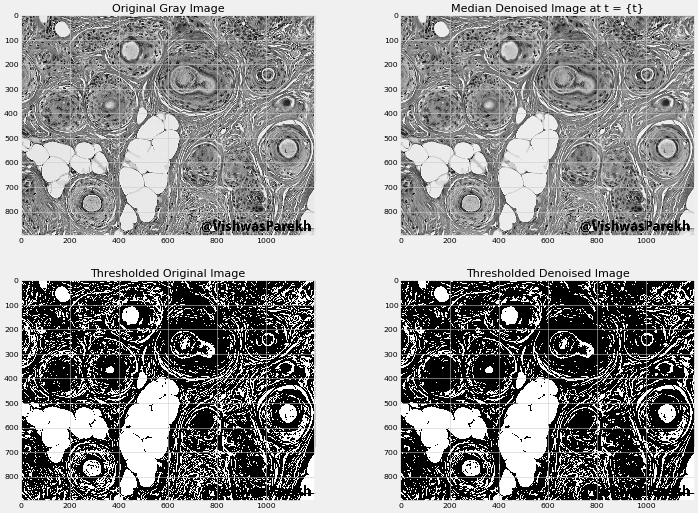

In [25]:
## denoise
dimg = cv2.medianBlur( gray_img, 3)
_, dtimg = cv2.threshold( dimg, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU )

ncolz=2
nrowz=2

plt.subplot(nrowz, ncolz, 1)
plot_image(gray_img, title=f'Original Gray Image');

plt.subplot(nrowz, ncolz, 2)
plot_image(dimg, title='Median Denoised Image at t = {t}');

plt.subplot(nrowz, ncolz, 3)
plot_image(timg, title='Thresholded Original Image');

plt.subplot(nrowz, ncolz, 4)
plot_image(dtimg, title='Thresholded Denoised Image');